In [2]:
from pandas import read_csv, DataFrame, concat
from datetime import datetime
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np 
import pandas as pd 



months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 
          'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
         'November': 11, 'December': 12}

def encode(l):
    encoded = []
    for m in l:
        for key, value in months.items():
            if key == m:
                encoded.append(value)
    return encoded


def parse(x):
    return datetime.strptime(x, '%m/%d/%Y')

# Data Loading
data_set = pd.read_csv('march2020clean.csv', sep =',', date_parser = parse)
data_set = data_set.iloc[:data_set['totalSoybeanMealSupply'].last_valid_index(),:] # Truncate dataset to those where every data is available 
'''
'closePrice','openPrice','highPrice','lowPrice','totalSoybeanMealSupply','totalSoybeanMealDemand','soybeanOilSupply','soybeanOilDemand','sunflowerSeedPrice','canolaPrice','peanutsPrice','flaxseedPrice','soybeanOilPrice','cottonseedOilPrice','sunflowerseedOilPrice','canolaOilPrice','peanutOilPrice','cornOilPrice','soybeanMealPrice','cottonseedmealPrice','sunflowerseedMealPrice','linseedMealPrice'
'''
target_col = ['closePrice','totalSoybeanMealSupply','totalSoybeanMealDemand', 'Month']
data_set['Month'] = encode(data_set['Month'])
data_set = data_set.loc[:,target_col]
shift = 8

In [3]:
data_set
values = data_set.values
values = values.astype('float32')
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaler2 = MinMaxScaler()
scaled2 = scaler2.fit_transform(values[:,0].reshape(-1,1))


In [4]:
def series_to_supervised(data, seq_length, y_col):
    X = [] 
    Y = []
    for time in range(len(data)-seq_length):
        X += [data[time:time+seq_length]]
        Y += [data[time+seq_length][y_col]]
    
    return X,Y

data_x, data_y = series_to_supervised(scaled,shift,[0,1,2,3])
data_x, data_y = np.asarray(data_x), np.asarray(data_y)
train_count = int(len(data_x) * 0.8)

train_x, train_y = data_x[:train_count,:,:], data_y[:train_count]
test_x, test_y = data_x[train_count:,:,:], data_y[train_count:]
print(train_x.shape)
print(train_y.shape)

(319, 8, 4)
(319, 4)


W1025 11:25:09.856204 16488 deprecation.py:506] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1025 11:25:10.214505 16488 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 319 samples, validate on 80 samples
Epoch 1/1000
319/319 - 1s - loss: 0.3800 - val_loss: 0.1287
Epoch 2/1000
319/319 - 0s - loss: 0.2091 - val_loss: 0.0473
Epoch 3/1000
319/319 - 0s - loss: 0.0974 - val_loss: 0.0429
Epoch 4/1000
319/319 - 0s - loss: 0.0860 - val_loss: 0.0290
Epoch 5/1000
319/319 - 0s - loss: 0.0739 - val_loss: 0.0284
Epoch 6/1000
319/319 - 0s - loss: 0.0626 - val_loss: 0.0274
Epoch 7/1000
319/319 - 0s - loss: 0.0560 - val_loss: 0.0249
Epoch 8/1000
319/319 - 0s - loss: 0.0509 - val_loss: 0.0237
Epoch 9/1000
319/319 - 0s - loss: 0.0454 - val_loss: 0.0228
Epoch 10/1000
319/319 - 0s - loss: 0.0496 - val_loss: 0.0219
Epoch 11/1000
319/319 - 0s - loss: 0.0410 - val_loss: 0.0220
Epoch 12/1000
319/319 - 0s - loss: 0.0417 - val_loss: 0.0188
Epoch 13/1000
319/319 - 0s - loss: 0.0390 - val_loss: 0.0181
Epoch 14/1000
319/319 - 0s - loss: 0.0360 - val_loss: 0.0169
Epoch 15/1000
319/319 - 0s - loss: 0.0326 - val_loss: 0.0159
Epoch 16/1000
319/319 - 0s - loss: 0.0335 - val_l

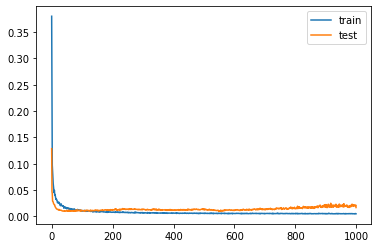

In [5]:
# design network
regressor = Sequential()
regressor.add(LSTM(units = 64, return_sequences = False, stateful = False, input_shape = (train_x.shape[1], train_x.shape[2])))
regressor.add(Dropout(0.1))
regressor.add(Dense(units = 32, activation='relu'))
regressor.add(Dropout(0.1))
regressor.add(Dense(units = 4))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = regressor.fit(train_x, train_y, epochs = 1000, batch_size = 32, validation_data=(test_x,test_y), verbose=2)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# print(model.get_weights())

In [6]:
'''
predictor = Sequential()
predictor.add(LSTM(units = 50, stateful = True, batch_input_shape = (1, None, train_x.shape[2])))
predictor.add(Dense(units = 3))
predictor.compile(optimizer = 'adam', loss = 'mean_squared_error')

predictor.set_weights(regressor.get_weights())

'''

"\npredictor = Sequential()\npredictor.add(LSTM(units = 50, stateful = True, batch_input_shape = (1, None, train_x.shape[2])))\npredictor.add(Dense(units = 3))\npredictor.compile(optimizer = 'adam', loss = 'mean_squared_error')\n\npredictor.set_weights(regressor.get_weights())\n\n"

(507, 4)


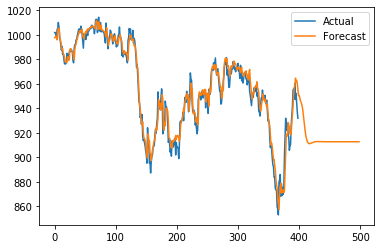

In [9]:
forecast_distance = 100

x_given = scaled[:,:]

x_hat = np.zeros((x_given.shape[0] + forecast_distance, x_given.shape[1]))
x_hat[:len(x_given),:] = x_given 
y_hat = np.zeros((x_given.shape[0] + forecast_distance))
print(x_hat.shape)
for i in range(shift, len(x_given)+forecast_distance):
    pred = regressor.predict(x_hat[i-shift:i,:].reshape(1,shift, x_given.shape[1]))
    if i >= len(x_given):
        x_hat[i,:] = pred 
    y_hat[i] = pred[0,0]
    #predictor.reset_states()

y_hat = y_hat[shift:]
    
yhat2 = regressor.predict(test_x)[:,0]

# invert scaling for forecast
inv_yhat = scaler2.inverse_transform(y_hat.reshape(-1,1))
# invert scaling for forecast
inv_yhat2 = scaler2.inverse_transform(yhat2.reshape(-1,1))
# invert scaling for actual
inv_y = scaler2.inverse_transform(np.concatenate((train_y[:,0],test_y[:,0]), axis=0).reshape(-1,1))


pyplot.figure()
pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Forecast')

pyplot.legend()
pyplot.show()